# Chapter 3 - Optimal Flows (Python Code)

In [ ]:
! pip install --upgrade quantecon_book_networks

We begin with some imports

In [1]:
import quantecon as qe
import quantecon_book_networks
import quantecon_book_networks.input_output as qbn_io
import quantecon_book_networks.plotting as qbn_plt
import quantecon_book_networks.data as qbn_data
ch3_data = qbn_data.optimal_flows()
export_figures = False

In [2]:
import numpy as np
from scipy.optimize import linprog
import networkx as nx
import ot
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Polygon
from matplotlib.artist import Artist  
quantecon_book_networks.config("matplotlib")

## Linear Programming and Duality

### Betweenness centrality (by color and node size) for the Florentine families

We load the Florentine Families data from the NetworkX package.

In [3]:
G = nx.florentine_families_graph()

Next we calculate betweenness centrality.

In [4]:
bc_dict = nx.betweenness_centrality(G)

And we produce the plot.

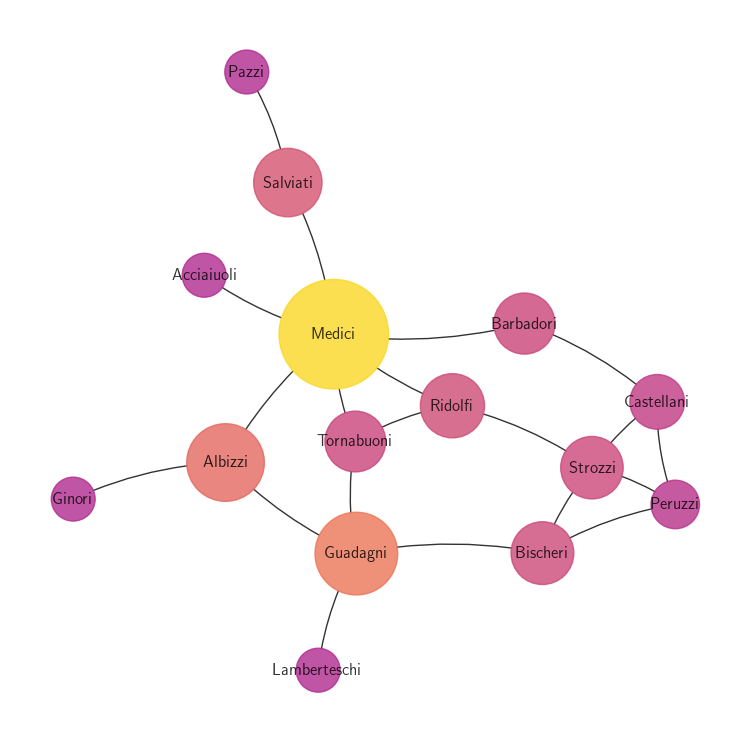

In [6]:
fig, ax = plt.subplots(figsize=(9.4, 9.4))

plt.axis("off")
nx.draw_networkx(
    G, 
    ax=ax,
    pos=nx.spring_layout(G, seed=1234), 
    with_labels=True,
    alpha=.8,
    arrows=True,
    arrowsize=15,
    connectionstyle="arc3,rad=0.1",
    node_size=[10_000*(size+0.1) for size in bc_dict.values()], 
    node_color=[cm.plasma(bc+0.4) for bc in bc_dict.values()],
)
if export_figures:
    plt.savefig("figures/betweenness_centrality_1.pdf")

### Revenue maximizing quantities and a Python implementation of linear programming

First we specify our linear program.

In [7]:
A = ((2, 5),
     (4, 2))
b = (30, 20)
c = (-3, -4) # minus in order to minimize

And now we use SciPy's linear programing module to solve our linear program.

In [8]:
from scipy.optimize import linprog
result = linprog(c, A_ub=A, b_ub=b)
print(result.x)

[2.5 5. ]


Here we produce a visualization of what is being done.

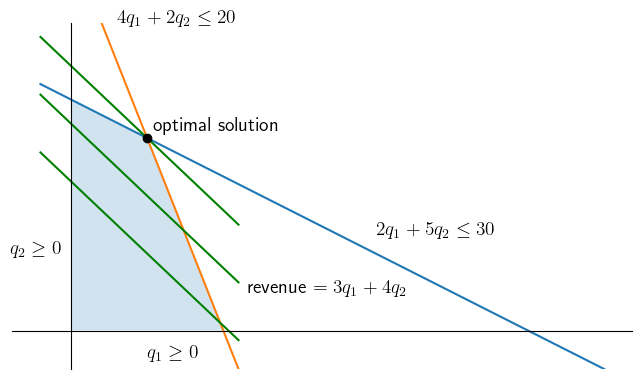

In [11]:
fig, ax = plt.subplots(figsize=(8, 4.5))
plt.rcParams['font.size'] = '14'

# Draw constraint lines

ax.plot(np.linspace(-1, 17.5, 100), 6-0.4*np.linspace(-1, 17.5, 100))
ax.plot(np.linspace(-1, 5.5, 100), 10-2*np.linspace(-1, 5.5, 100))
ax.text(10, 2.5, r"$2q_1 + 5q_2 \leq 30$")
ax.text(1.5, 8, r"$4q_1 + 2q_2 \leq 20$")
ax.text(-2, 2, r"$q_2 \geq 0$")
ax.text(2.5, -0.7, r"$q_1 \geq 0$")

# Draw the feasible region
feasible_set = Polygon(np.array([[0, 0], 
                                 [0, 6], 
                                 [2.5, 5], 
                                 [5, 0]]))
ax.add_artist(feasible_set)
Artist.set_alpha(feasible_set, 0.2) 

# Draw the objective function
ax.plot(np.linspace(-1, 5.5, 100), 3.875-0.75*np.linspace(-1, 5.5, 100), 'g-')
ax.plot(np.linspace(-1, 5.5, 100), 5.375-0.75*np.linspace(-1, 5.5, 100), 'g-')
ax.plot(np.linspace(-1, 5.5, 100), 6.875-0.75*np.linspace(-1, 5.5, 100), 'g-')
ax.text(5.8, 1, r"revenue $ = 3q_1 + 4q_2$")

# Draw the optimal solution
ax.plot(2.5, 5, "o", color="black")
ax.text(2.7, 5.2, "optimal solution")

for spine in ['right', 'top']:
    ax.spines[spine].set_color('none')
    
ax.set_xticks(())
ax.set_yticks(())

for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    
ax.set_ylim(-1, 8)

if export_figures:
    plt.savefig("figures/linear_programming_1.pdf")
plt.show()

## Optimal Transport
 

### Transforming one distribution into another

Below we provide code to produce a visualization of transforming one
distribution into another in one dimension.

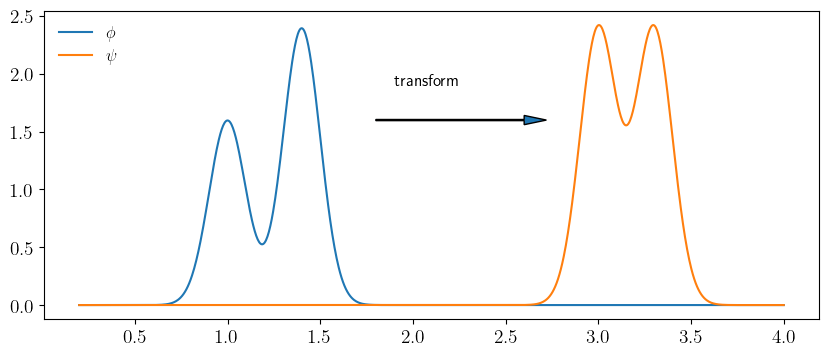

In [12]:
σ = 0.1

def ϕ(z):
    return (1 / np.sqrt(2 * σ**2 * np.pi)) * np.exp(-z**2 / (2 * σ**2))

def v(x, a=0.4, b=0.6, s=1.0, t=1.4):
    return a * ϕ(x - s) + b * ϕ(x - t)

fig, ax = plt.subplots(figsize=(10, 4))

x = np.linspace(0.2, 4, 1000)
ax.plot(x, v(x), label="$\\phi$")
ax.plot(x, v(x, s=3.0, t=3.3, a=0.6), label="$\\psi$")

ax.legend(loc='upper left', fontsize=12, frameon=False)

ax.arrow(1.8, 1.6, 0.8, 0.0, width=0.01, head_width=0.08)
ax.annotate('transform', xy=(1.9, 1.9), fontsize=12)
if export_figures:
    plt.savefig("figures/ot_figs_1.pdf")
plt.show()

### Function to solve a transport problem via linear programming

Here we define a function to solve optimal transport problems using linear programming.

In [13]:
def ot_solver(phi, psi, c, method='highs-ipm'):
    """
    Solve the OT problem associated with distributions phi, psi
    and cost matrix c.
    Parameters
    ----------
    phi : 1-D array
    Distribution over the source locations.
    psi : 1-D array
    Distribution over the target locations.
    c : 2-D array
    Cost matrix.
    """
    n, m = len(phi), len(psi)

    # vectorize c
    c_vec = c.reshape((m * n, 1), order='F')

    # Construct A and b
    A1 = np.kron(np.ones((1, m)), np.identity(n))
    A2 = np.kron(np.identity(m), np.ones((1, n)))
    A = np.vstack((A1, A2))
    b = np.hstack((phi, psi))

    # Call sover
    res = linprog(c_vec, A_eq=A, b_eq=b, method=method)

    # Invert the vec operation to get the solution as a matrix
    pi = res.x.reshape((n, m), order='F')
    return pi

Now we can set up a simple optimal transport problem.

In [14]:
phi = np.array((0.5, 0.5))
psi = np.array((1, 0))
c = np.ones((2, 2))

Next we solve using the above function.

In [15]:
ot_solver(phi, psi, c)

array([[ 0.5, -0. ],
       [ 0.5,  0. ]])

We see we get the same result as when using the Python optimal transport
package.

In [16]:
ot.emd(phi, psi, c) 

array([[0.5, 0. ],
       [0.5, 0. ]])

### An optimal transport problem solved by linear programming

Here we demonstrate a more detailed optimal transport problem. We begin by defining a node class.

In [17]:
class Node:

    def __init__(self, x, y, mass, group, name):

        self.x, self.y = x, y
        self.mass, self.group = mass, group
        self.name = name

Now we define a function for randomly generating nodes.

In [18]:
from scipy.stats import betabinom

def build_nodes_of_one_type(group='phi', n=100, seed=123):

    nodes = []
    np.random.seed(seed)

    for i in range(n):
        
        if group == 'phi':
            m = 1/n
            x = np.random.uniform(-2, 2)
            y = np.random.uniform(-2, 2)
        else:
            m = betabinom.pmf(i, n-1, 2, 2)
            x = 0.6 * np.random.uniform(-1.5, 1.5)
            y = 0.6 * np.random.uniform(-1.5, 1.5)
            
        name = group + str(i)
        nodes.append(Node(x, y, m, group, name))

    return nodes

We now generate our source and target nodes.

In [19]:
n_phi = 32
n_psi = 32

phi_list = build_nodes_of_one_type(group='phi', n=n_phi)
psi_list = build_nodes_of_one_type(group='psi', n=n_psi)

phi_probs = [phi.mass for phi in phi_list]
psi_probs = [psi.mass for psi in psi_list]

Now we define our transport costs.

In [20]:
c = np.empty((n_phi, n_psi))
for i in range(n_phi):
    for j in range(n_psi):
        x0, y0 = phi_list[i].x, phi_list[i].y
        x1, y1 = psi_list[j].x, psi_list[j].y
        c[i, j] = np.sqrt((x0-x1)**2 + (y0-y1)**2)

We solve our optimal transport problem using the Python optimal transport package.

In [21]:
pi = ot.emd(phi_probs, psi_probs, c)

Finally we produce a graph of our sources, targets, and optimal transport plan.

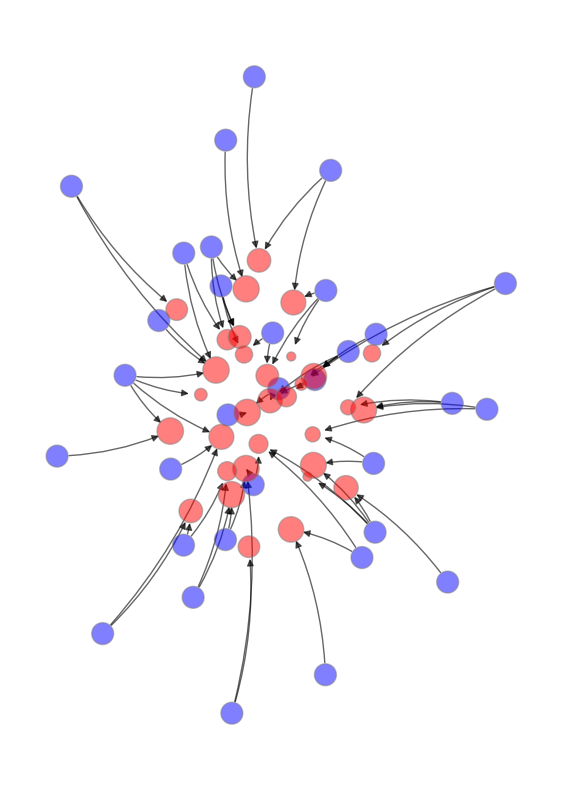

In [22]:
g = nx.DiGraph()
g.add_nodes_from([phi.name for phi in phi_list])
g.add_nodes_from([psi.name for psi in psi_list])

for i in range(n_phi):
    for j in range(n_psi):
        if pi[i, j] > 0:
            g.add_edge(phi_list[i].name, psi_list[j].name, weight=pi[i, j])

node_pos_dict={}
for phi in phi_list:
    node_pos_dict[phi.name] = (phi.x, phi.y)
for psi in psi_list:
    node_pos_dict[psi.name] = (psi.x, psi.y)

node_color_list = []
node_size_list = []
scale = 8_000
for phi in phi_list:
    node_color_list.append('blue')
    node_size_list.append(phi.mass * scale)
for psi in psi_list:
    node_color_list.append('red')
    node_size_list.append(psi.mass * scale)

fig, ax = plt.subplots(figsize=(7, 10))
plt.axis('off')

nx.draw_networkx_nodes(g, 
                       node_pos_dict, 
                       node_color=node_color_list,
                       node_size=node_size_list,
                       edgecolors='grey',
                       linewidths=1,
                       alpha=0.5,
                       ax=ax)

nx.draw_networkx_edges(g, 
                       node_pos_dict, 
                       arrows=True,
                       connectionstyle='arc3,rad=0.1',
                       alpha=0.6)
if export_figures:
    plt.savefig("figures/ot_large_scale_1.pdf")
plt.show()

### Solving linear assignment as an optimal transport problem

Here we set up a linear assignment problem (matching $n$ workers to $n$ jobs).

In [23]:
n = 4
phi = np.ones(n)
psi = np.ones(n)

We generate our cost matrix (the cost of training the $i$th worker for the $j$th job)

In [24]:
c = np.random.uniform(size=(n, n))

Finally, we solve our linear assignment problem as a special case of optimal transport.

In [25]:
ot.emd(phi, psi, c)

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

### Python Spatial Analysis library

Readers interested in computational optimal transport should also consider
PySAL, the [Python Spatial Analysis library](https://pysal.org/). See, for
example, https://pysal.org/spaghetti/notebooks/transportation-problem.html.

### The General Flow Problem

Here we solve a simple network flow problem as a linear program. We begin by
defining the node-edge incidence matrix.

In [26]:
A = (
( 1,  1,  0,  0),
(-1,  0,  1,  0),
( 0,  0, -1,  1),
( 0, -1,  0, -1)
)

Now we define exogenous supply and transport costs.

In [27]:
b = (10, 0, 0, -10)
c = (1, 4, 1, 1)

Finally we solve as a linear program.

In [28]:
result = linprog(c, A_eq=A, b_eq=b, method='highs-ipm')
print(result.x)

[10.  0. 10. 10.]
